In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import time
import pickle
# import json
import importlib
import matplotlib.pyplot as plt

from config import ms_coco_dir

In [2]:
# use xception descriptors

xc_train = pickle.load(open(ms_coco_dir + '/descriptors/xception/xception-train2017-descriptors.pic', 'rb'))
xc_val = pickle.load(open(ms_coco_dir + '/descriptors/xception/xception-val2017-descriptors.pic', 'rb'))

descriptors_train = xc_train
descriptors_val = xc_val

## Train

Or skip this and just load some model in the inference section

In [8]:
freq_threshold = 0
train_size = 100
num_steps = 50

embeding_size = 200
batch_size = 5
lstm_size = 200
checkpoint_path = 'checkpoints/coco-caption.ckp'
image_descriptor_size = X_images.shape[1]

In [30]:
import utils
importlib.reload(utils)
from utils import load_and_save_captions, load_captions_and_images

load_and_save_captions(ms_coco_dir, train_size, num_steps, freq_threshold)
X_images, X_captions, Y, X_lens, vocab_size, caption_ids = load_captions_and_images(descriptors_train)

loading annotations into memory...
Done (t=1.89s)
creating index...
index created!
# of images 118287 # of captions 591753 # of captions per image 5.002688376575617
Tokenization...
... tokenization done.
Building vocabulary...
Saving vocab to vocab.pic
vocab size 310
... building vocabulary done.
Processing captions...
... processing captions done.
Saving (X_captions, X_lens, Y, caption_ids) to XY.pic


In [10]:
X_images.shape, X_captions.shape, vocab_size

((100, 2048), (100, 50), 310)

In [11]:
from lstm_captioning_model import RNNCaptioningModel

In [12]:
tf.reset_default_graph()
sess = tf.Session()
model = RNNCaptioningModel(embedding_size=embeding_size, image_descriptor_size=image_descriptor_size, lstm_size=lstm_size, num_steps=num_steps, vocab_size=vocab_size, sess=sess, checkpoint_path=checkpoint_path)
model.build(model_type='train')

In [13]:
sess.run(tf.global_variables_initializer())
# model.saver.restore(sess, checkpoint_path + '-final') # continue training

In [14]:
n_epochs = 10
learning_rate = 0.001
model.train(X_images, X_captions, Y, X_lens, n_epochs, batch_size, learning_rate, evaluate_every=20, save_every=100)

n_epochs = 20
learning_rate = 0.0001
model.train(X_images, X_captions, Y, X_lens, n_epochs, batch_size, learning_rate, evaluate_every=20, save_every=100)

epoch 1
training loss after 20 steps: 3.68624687195 elapsed time: 00h 00m 03s
epoch 2
training loss after 40 steps: 2.50168204308 elapsed time: 00h 00m 06s
epoch 3
training loss after 60 steps: 1.75109219551 elapsed time: 00h 00m 10s
epoch 4
training loss after 80 steps: 1.17539286613 elapsed time: 00h 00m 13s
epoch 5
training loss after 100 steps: 0.761193573475 elapsed time: 00h 00m 16s
saved model to checkpoints/coco-caption.ckp-100
epoch 6
training loss after 120 steps: 0.517965734005 elapsed time: 00h 00m 21s
epoch 7
training loss after 140 steps: 0.380921781063 elapsed time: 00h 00m 24s
epoch 8
training loss after 160 steps: 0.321037262678 elapsed time: 00h 00m 28s
epoch 9
training loss after 180 steps: 0.304425597191 elapsed time: 00h 00m 31s
epoch 10
training loss after 200 steps: 0.24826925993 elapsed time: 00h 00m 34s
saved model to checkpoints/coco-caption.ckp-200
Finished training
Saved final model to checkpoints/coco-caption.ckp-final
Final training loss: 0.248269230127
It

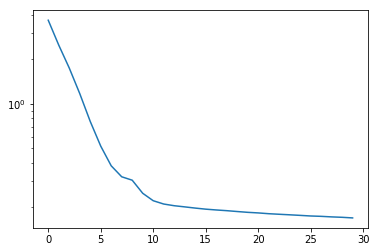

In [15]:
losses = np.load('losses.npy')
plt.semilogy(losses)

## Infer

In [16]:
# We need to download the vocab, because the tokenization is done differently there than on my laptop (don't know why).
with open('vocab.pic', 'rb') as f:
    vocab = pickle.load(f)
id_word = [v[0] for v in vocab]
word_id = {w:i for i,w in enumerate(id_word)}
vocab_size = len(vocab)
vocab_size

310

In [17]:
tf.reset_default_graph()
sess = tf.Session()
model = RNNCaptioningModel(embedding_size=embeding_size, image_descriptor_size=image_descriptor_size, lstm_size=lstm_size, num_steps=num_steps, vocab_size=vocab_size, sess=sess, checkpoint_path=checkpoint_path)
model.build(model_type='infer')
model.saver.restore(sess, checkpoint_path + '-final')

INFO:tensorflow:Restoring parameters from checkpoints/coco-caption.ckp-final


In [35]:
from pycocotools.coco import COCO
coco = COCO(ms_coco_dir + '/annotations/captions_train2017.json')

loading annotations into memory...
Done (t=1.90s)
creating index...
index created!


In [37]:
num_sentences = 20

for i in range(num_sentences):
    idx = np.random.choice(X_captions.shape[0])
    
    seq = model.infer(X_images[idx].reshape(1,-1), start_id=word_id['START'], end_id=word_id['END'])
    print('PRED:', ' '.join([id_word[w] for w in seq if id_word[w] not in ('START', 'END')]))
    
    imgId = caption_ids[idx]
    annIds = coco.getAnnIds(imgIds=[imgId])
    anns = coco.loadAnns(annIds)
    for a in anns:
        print('TRUE:', a['caption'])
    print()

PRED: A kitchen is shown with a variety of items on the counters .
TRUE: A kitchen is shown with a variety of items on the counters.
TRUE: A kitchen has the windows open and plaid curtains.
TRUE: A kitchen with two windows and two metal sinks.
TRUE: An older kitchen with cluttered counter tops but empty sink.
TRUE: Glasses and bottles are placed near a kitchen sink.

PRED: A kitchen with wood floors and lots of furniture .
TRUE: A kitchen with wood floors and lots of furniture.
TRUE: A beautiful, open kitchen and dining room area features an island in the center and wood cabinets and large windows.
TRUE: A kitchen made of mostly wood with a small desk with a laptop.
TRUE: A very spacious room with a kitchen and dining area.
TRUE: A full view of an open kitchen and dining area.

PRED: Two cooks are near the stove in a stainless steel kitchen .
TRUE: Two chefs in a restaurant kitchen preparing food. 
TRUE: Two cooks are cooking the food someone ordered at this restaurant
TRUE: The chef i